In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import openai
from sklearn.model_selection import GridSearchCV
import json
warnings.filterwarnings("ignore")
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity as cosine
import math
from sentence_transformers import SentenceTransformer
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

C:\Users\nivba\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

### create data and organize it

In [3]:
all_files = glob.glob(os.path.join("./", "*.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)[['round_no','query_id','group','username', 'position1', 'position2', 'position3','posted_document']]
df[["position1","position2","position3"]] = df[["position1","position2","position3"]].astype(int)/10
df["med_score"] = df[["position1","position2","position3"]].median(axis=1)
df["mean_score"] = df[["position1","position2","position3"]].mean(axis=1)

In [4]:
keys_ = list(df.groupby(['round_no','query_id','group']).size().index)
tops = []
for round_no_, query_id_, group_ in set(keys_):
    top = df[(df.round_no == round_no_) & (df.query_id == query_id_) & (df.group == group_)]
    top = top[top.med_score == top.med_score.min()]
    # if len(top) > 1:
    #     top = top[top.mean_score == top.mean_score.min()]
    # if len(top) > 1:
    #     top = top[top.username != "dummy"]
    # if len(top) > 1:
    #     top = top[~top.username.str.contains("BOT")]
    # if len(top) > 1:
    #     top = top.head(1)
    tops.append(top)    

In [5]:
topic_data = json.load(open(fr'initials.json', encoding="utf8"))
topic_df = pd.DataFrame(topic_data)[["_id", "queries"]]
topic_df._id = topic_df._id.astype(int) 

In [6]:
tops_df = pd.concat(tops).sort_values(["round_no","query_id","group"])
tops_df = tops_df.merge(topic_df, how="left", right_on = "_id", left_on = "query_id")

In [7]:
data = tops_df[["round_no", "query_id", "group", "posted_document", "queries"]].to_dict('records')

In [24]:
for idx, row in tops_df.iterrows():
    tops_df.at[idx,"query_1"],tops_df.at[idx,"query_2"],tops_df.at[idx,"query_3"] = tops_df.loc[idx, "queries"]

In [ ]:
tops_df.info()

In [29]:
for idx, row in tqdm(tops_df.iterrows()):
    tops_df.at[idx, "cos_q_1"] = cosine(model.encode([row["query_1"]]),model.encode([row["posted_document"]]))
    tops_df.at[idx, "cos_q_2"] = cosine(model.encode([row["query_2"]]),model.encode([row["posted_document"]]))
    tops_df.at[idx, "cos_q_3"] = cosine(model.encode([row["query_3"]]),model.encode([row["posted_document"]]))

511it [05:13,  1.63it/s]


### assemble cossine similarities

In [7]:
ft_df = pd.read_csv("../fine_tuning_files/fine_tuning_3.csv")
ft_df["cosine"] = np.nan

In [12]:
for idx, row in tqdm(ft_df.iterrows()):
    if not math.isnan(row["cosine"]):
        continue
    ft_df.at[idx, "cosine"] = cosine(model.encode([row["posted_document"]]),model.encode([row["suggested_document"]]))
    if idx%1000 == 0:
        ft_df.to_csv("../fine_tuning_files/fine_tuning_3.csv", index=False)
ft_df.to_csv("../fine_tuning_files/fine_tuning_3.csv", index=False)

31023it [00:00, 41859.60it/s]


### visualize results

In [4]:
ft_df = pd.read_csv("../fine_tuning_files/fine_tuning_3.csv")

In [5]:
ft_df["key"] = ft_df.apply(lambda row: "_".join([str(row.temperature), str(row.top_p), str(row.frequency_penalty), str(row.presence_penalty)]), axis=1)

In [6]:
lm_df = ft_df[ft_df.group.isin(["A","B"])]
brt_df = ft_df[ft_df.group.isin(["C","D"])]

In [132]:
def show_horizontal_error_bars(df,p_vals):
    means = ft_df.groupby(['temperature', 'top_p', 'frequency_penalty', 'presence_penalty']).mean()["cosine"].to_dict()
    stds = ft_df.groupby(['temperature', 'top_p', 'frequency_penalty', 'presence_penalty']).std()["cosine"].to_dict()
    rows = []
    for key in means.keys():
        rows.append({"key":key, "mean":means[key], "std":stds[key]})
    stat_df = pd.DataFrame(rows)
    stat_df[["mean","std"]] = stat_df[["mean","std"]].astype(float)
    stat_df.key = stat_df.key.astype(str)
    df = stat_df
    df.sort_values(by='mean', ascending=True, inplace=True)
    plt.figure(figsize=(10, 20))
    plt.barh(df['key'], df['mean'], xerr=df['std'], capsize=4)
    plt.xlabel('Mean Cosine Similarity')
    plt.ylabel("""('temperature', 'top_p', 'frequency_penalty', 'presence_penalty')""")
    plt.title('Mean Cosine Similarity with Error Bars')
    plt.show()

In [156]:
def show_scatter_parameters(df):
    p_vals = dict()
    for col in ['temperature', 'top_p', 'frequency_penalty', 'presence_penalty']:
        plt.figure(figsize=(12, 10))
        sns.scatterplot(data=df, x=col, y="cosine")
        plt.xlabel(col)
        plt.ylabel("cosine")
        plt.title(f'Distribution of cosine by {col}')
        m = df.groupby(col).mean().to_dict()["cosine"]
        s = df.groupby(col).std().to_dict()["cosine"]
        med = df.groupby(col).median().to_dict()["cosine"]
        # sns.lineplot(x= m.keys(), y=m.values(), color="red")
        sns.scatterplot(x= m.keys(), y=m.values(), color="red", s=100)
        sns.scatterplot(x= med.keys(), y=med.values(), color="green", s=100)
        uniques = list(df[col].unique())
        result_anova = stats.f_oneway(df["cosine"][df[col] == uniques[0]],
                        df["cosine"][df[col] == uniques[1]],
                        df["cosine"][df[col] == uniques[2]])
        for x,y in m.items():
            plt.annotate(text = f"{col}={x}\nmean (red):{round(y,3)}\nstd:{round(s[x],3)}\nmedian (green):{round(med[x],3)}", xy= (x+0.02,(y+med[x])/2))
        plt.show()
        print("One-way ANOVA p-value:", result_anova.pvalue)
        # Check if ANOVA result is significant
#         if result_anova.pvalue <= 0.05:
#             # Perform Tukey's HSD test
#             tukey_result = pairwise_tukeyhsd(df['cosine'], df[col])

#             # Check if there are significant differences
#             if any(tukey_result.reject):
#                 print(tukey_result.groups)
#                 # Get the group(s) with significantly higher means
#                 groups_with_higher_means = tukey_result._multicomp.pairindices[tukey_result.reject]

#                 # Find the maximum mean among the significant groups
#                 max_mean = df.loc[df[col].isin(groups_with_higher_means), 'cosine'].mean()

#                 # Find the group(s) with the maximum mean
#                 groups_with_max_mean = df.loc[df['cosine'] == max_mean, col].unique()

#                 print("Group(s) with significantly higher means:", groups_with_max_mean)
#                 print("Maximum mean:", max_mean)
#         else:
#             print("No significant difference detected.")
    return p_vals

## LambdaMART graphs

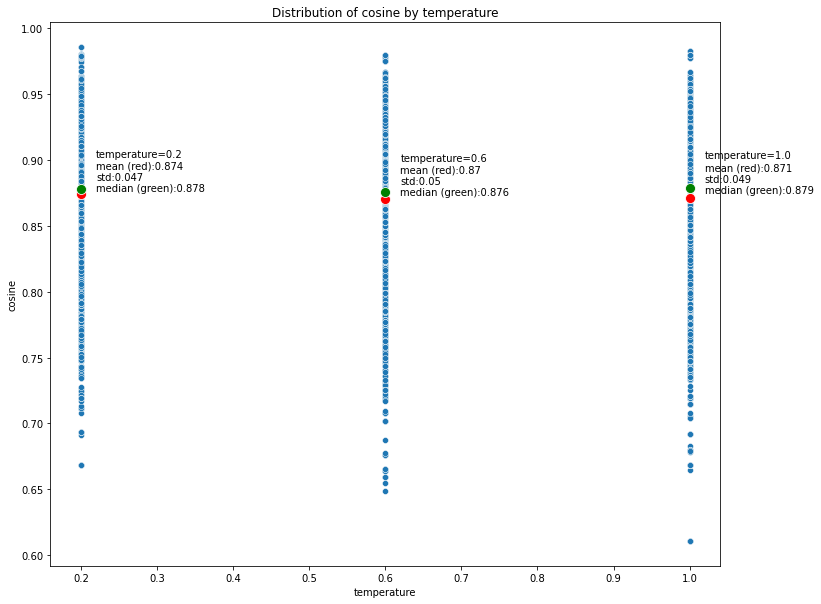

One-way ANOVA p-value: 9.599216955282595e-05


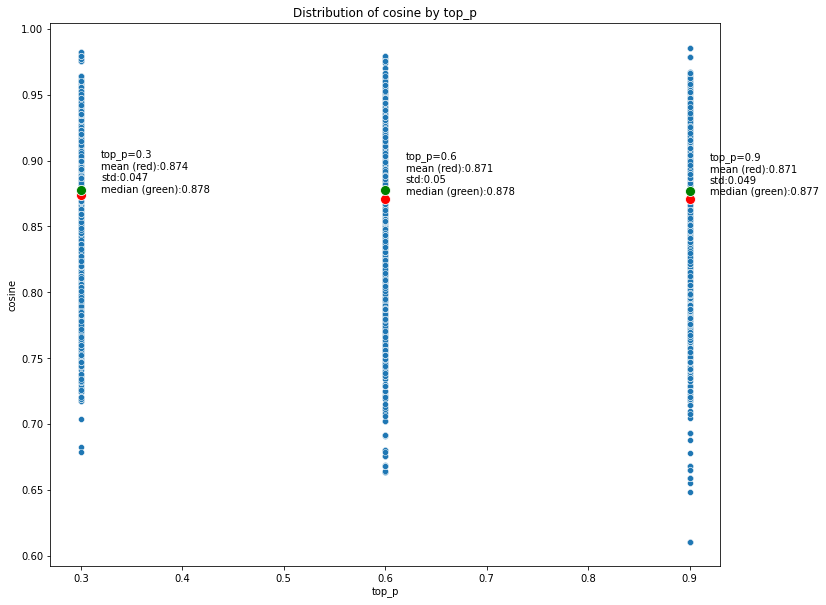

One-way ANOVA p-value: 0.0012938118633098235


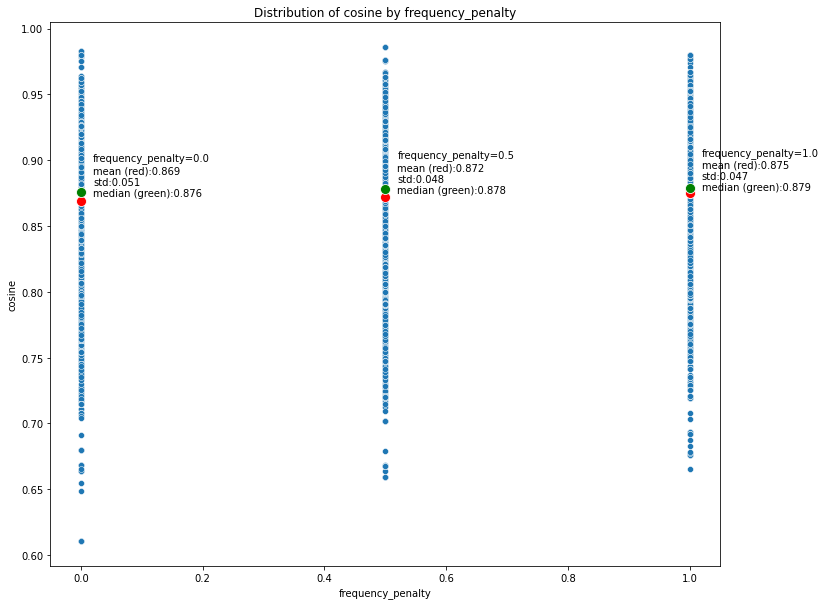

One-way ANOVA p-value: 3.358015428181861e-08


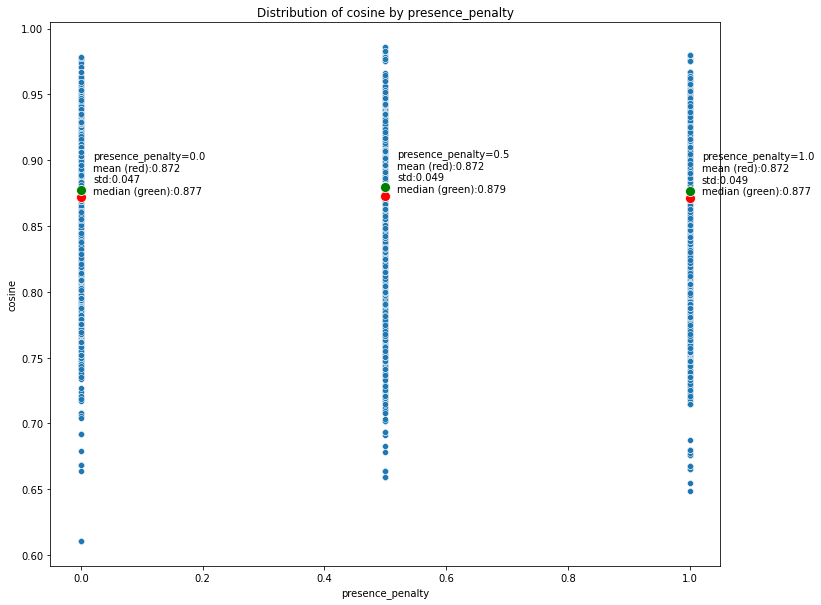

One-way ANOVA p-value: 0.6390594536454488


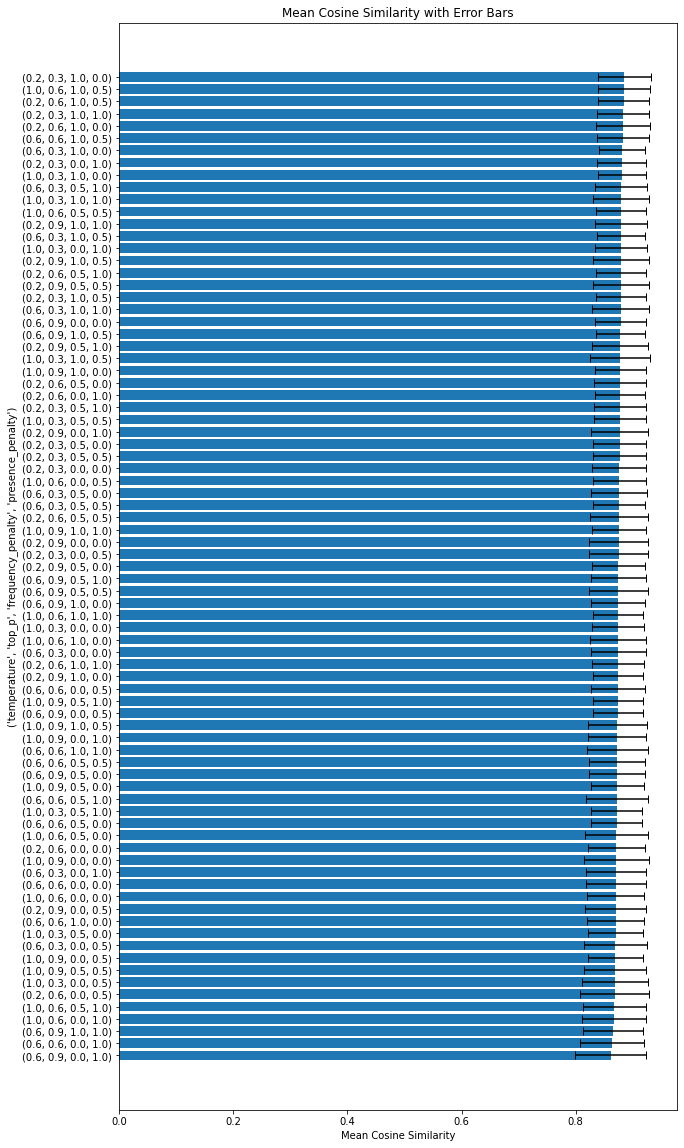

In [157]:
p_vals = show_scatter_parameters(lm_df)
show_horizontal_error_bars(lm_df,p_vals)

## BERT graphs

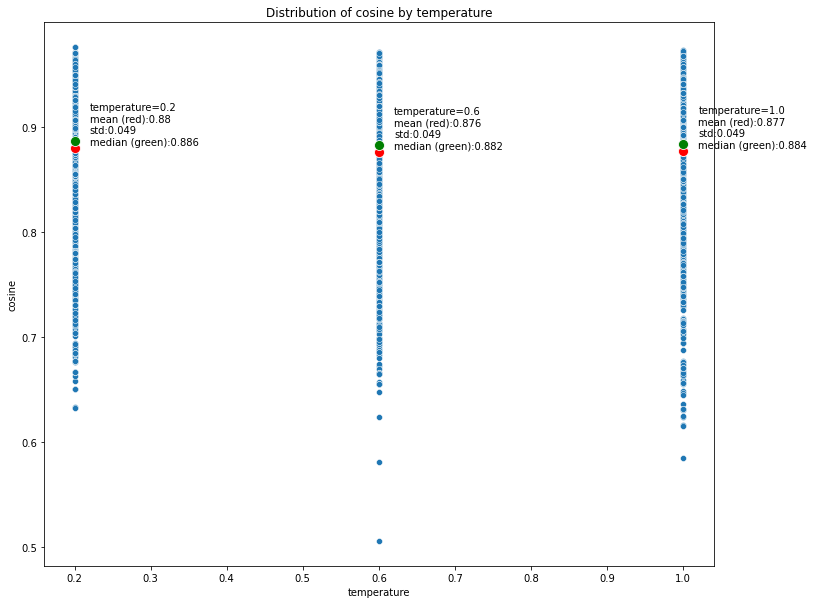

One-way ANOVA p-value: 0.00014544501177496473


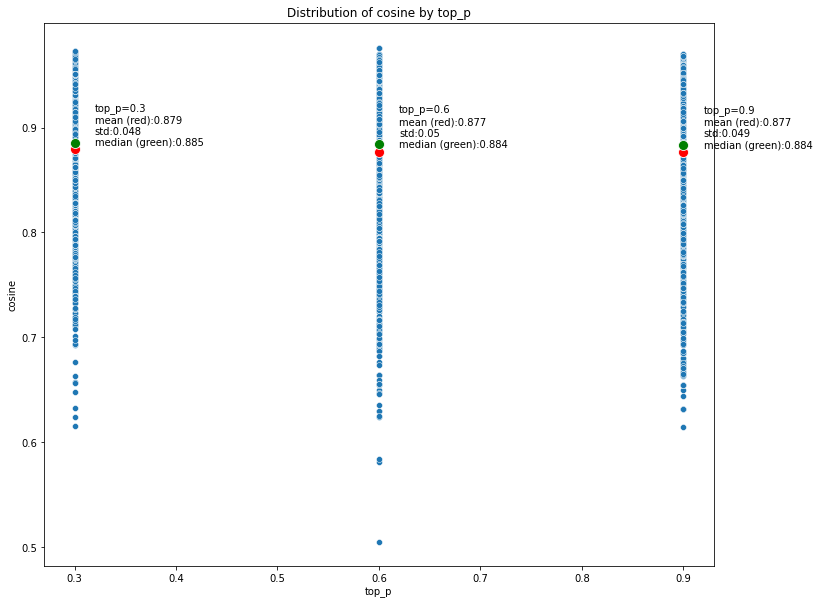

One-way ANOVA p-value: 0.005673560205483495


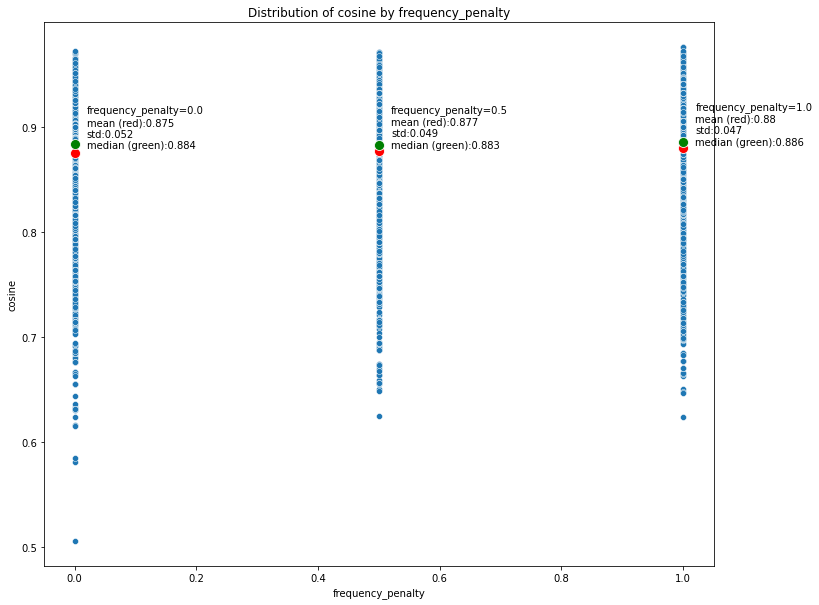

One-way ANOVA p-value: 2.8941047492385753e-07


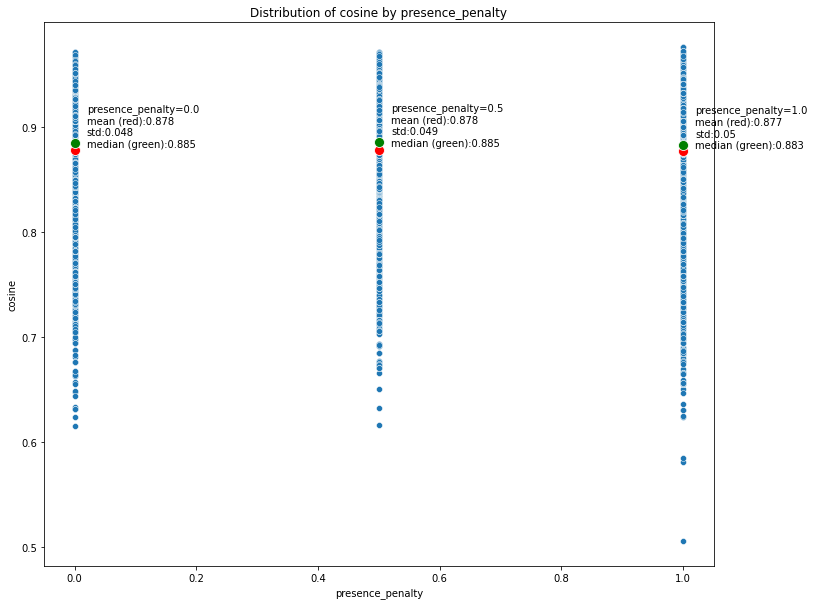

One-way ANOVA p-value: 0.23547159705102713


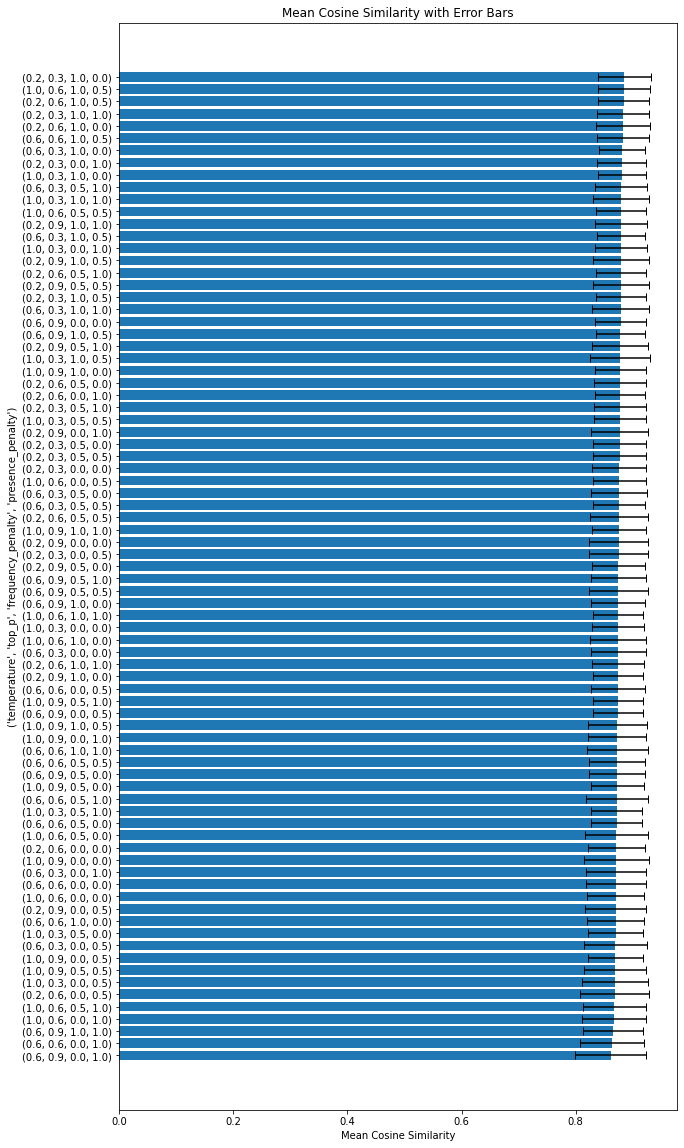

In [143]:
p_vals = show_scatter_parameters(brt_df)
show_horizontal_error_bars(brt_df,p_vals)

In [33]:
!jupyter nbconvert fine_tune.ipynb --to html --no-input 

[NbConvertApp] Converting notebook fine_tune.ipynb to html
[NbConvertApp] Writing 1296458 bytes to fine_tune.html
